# ITC experiment simulation

This notebook performs analyses described in the 

**Manuscript:**

Modelling the decamerisation cycle of PRDX1 and the inhibition-like effect on its peroxidase activity

**Authors:**

C. Barry, C. Pillay, J. Rohwer

**Purpose:**

Writes: Barranco-Medina 2008 Fig. 1a Arabidopsis thaliana injection parameters (filename: `ITC_At_inject_params.csv`)

Analysis: Demonstrate ITC model using published parameters i.e. against Barranco-Medina 2008 Fig. 1a

Analysis: Test different baseline correction methods

Plot: Figure 3

**Requirements:**

Python libraries (see **Imports** below)

ITC Prx dimer-decamer equilibrium model (`ITC_Prx_dim-dec.psc`)

##### Imports

In [1]:
import os
import math

import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import auc
from scipy.interpolate import interp1d

import pysces


Matplotlib backend set to: "nbAgg"
Matplotlib interface loaded (pysces.plt.m)
Pitcon routines available
NLEQ2 routines available
SBML support available
You are using NumPy (1.23.5) with SciPy (1.9.3)
Assimulo CVode available
RateChar is available
Parallel scanner is available

PySCeS environment
******************
pysces.model_dir = /home/chris/Pysces/psc
pysces.output_dir = /home/chris/Pysces


***********************************************************************
* Welcome to PySCeS (1.0.3) - Python Simulator for Cellular Systems   *
*                http://pysces.sourceforge.net                        *
* Copyright(C) B.G. Olivier, J.M. Rohwer, J.-H.S. Hofmeyr, 2004-2022  *
* Triple-J Group for Molecular Cell Physiology                        *
* Stellenbosch University, ZA and VU University Amsterdam, NL         *
* PySCeS is distributed under the PySCeS (BSD style) licence, see     *
* LICENCE.txt (supplied with this release) for details                *
* Please cite PySCeS with

###### Get directory paths

In [2]:
prev_dir = os.path.split(os.getcwd())[0]

mod_dir = os.path.join(prev_dir,"models")
if not os.path.isdir(mod_dir): os.mkdir(mod_dir) # ensure dir exists

par_dir = os.path.join(prev_dir,"params")
if not os.path.isdir(par_dir): os.mkdir(par_dir) # ensure dir exists
    
fig_dir = os.path.join(os.getcwd(),"Figures")
if not os.path.isdir(fig_dir): os.mkdir(fig_dir) # ensure dir exists


##### Matplotlib stuff

In [3]:
%matplotlib inline

multiplier = 1
mpl_width = 4.5*multiplier
mpl_height = 3.5*multiplier
mpl_dpi = 600
mpl_xlabel_fontsize = "large"
mpl_ylabel_fontsize = "large"
mu = "\u03bc"

##### Coswave

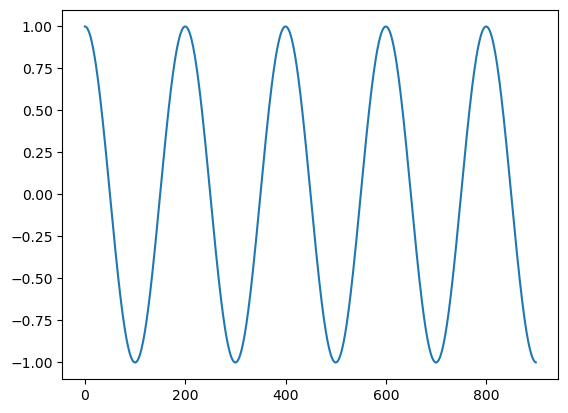

In [4]:
time_range = range(900)
injection_interval = 200 # period
coswave = np.array([np.cos(_TIME_*2*np.pi/(injection_interval)) for _TIME_ in time_range])
plt.plot(time_range, coswave)

## Model

### Inject params

In [5]:
inj_enthalpy_At = 142 # +- 24 kcal/mol of dimer
inj_volume_At = 1.6 # ul
inj_mon_At = 70 # uM MONOMERS
inj_dim_est_At = 0.8
inj_dec_est_At = (inj_mon_At/2 - 0.8)/5
inj_interval_At = 180 # sec


In [7]:
# Set up df to update models
entry = {"Parameter": [ "injection_enthalpy",
                        "injection_volume",
                        "injection_Prx_mon",
                        "injection_dimer",
                        "injection_decamer",
                        "injection_interval",
                        "first_inject_ratio"],
         
       "Value":[inj_enthalpy_At,
                inj_volume_At,
                inj_mon_At,
                inj_dim_est_At, 
                inj_dec_est_At,
                inj_interval_At,
                1]}

df_ITC_At_inject_params = pd.DataFrame(entry)
df_ITC_At_inject_params.set_index("Parameter",inplace=True)

# # Adjust to values calculated from the figure (differs to text)
df_ITC_At_inject_params["Value"].loc["injection_dimer"] = df_ITC_At_inject_params["Value"].loc["injection_dimer"]*1.25
df_ITC_At_inject_params["Value"].loc["injection_decamer"] = df_ITC_At_inject_params["Value"].loc["injection_decamer"]*1.25

df_ITC_At_inject_params


,Value
Parameter,
injection_enthalpy,142.00
injection_volume,1.60
injection_Prx_mon,70.00
injection_dimer,1.00
injection_decamer,8.55
injection_interval,180.00
first_inject_ratio,1.00


In [8]:
# Write to file
df_ITC_At_inject_params.to_csv(os.path.join(par_dir, "ITC_At_inject_params.csv"), sep=',', encoding='utf-8')
df_ITC_At_inject_params.to_csv(os.path.join(par_dir, "ITC_At_inject_params.csv"), sep=',', encoding='utf-8')


## ITC Prx dec model expo 130

In [9]:
# Load ITC model
mod_ITC_Prx_dec_onestep = pysces.model("ITC_Prx_dim-dec.psc", dir=mod_dir)
mod_ITC_Prx_dec_onestep.mode_integrate_all_odes = True # As recommented by pysces
mod_ITC_Prx_dec_onestep.SetQuiet()

# Update model with inject params (the mod.__dict__.update() doesn't work here)
for parameter in df_ITC_At_inject_params.index:
    setattr(mod_ITC_Prx_dec_onestep,parameter,df_ITC_At_inject_params["Value"].loc[parameter])
    
# Adjust to e=130
mod_ITC_Prx_dec_onestep.exponent = 130
mod_ITC_Prx_dec_onestep.Kd_app = 2.4*10**(-10)

# Update with arbitrary rates for pretty plots
mod_ITC_Prx_dec_onestep.koff = 5
mod_ITC_Prx_dec_onestep.kon = mod_ITC_Prx_dec_onestep.koff/mod_ITC_Prx_dec_onestep.Kd_app
    
mod_ITC_Prx_dec_onestep.showModel()

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/ITC_Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/ITC_Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Kd_app" has been initialised but does not occur in a rate equation
Info: "injection_volume" has been initialised but does not occur in a rate equation
Info: "injection_dimer" has been initialised but does not occur in a rate equation
Info: "injection_decamer" has been initialised but does not occur in a rate equation
Info: "injection_interval" has been initialised but does not occur in a rate equation
Info: "first_inject_ratio" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conserv

### Equilibrium in syringe

In [10]:
# Load Prx dim-dec model
mod_Prx_dim_dec = pysces.model("Prx_dim-dec.psc", dir = mod_dir)
mod_Prx_dim_dec.SetQuiet()

# Update model with inject params (the mod.__dict__.update() doesn't work here)
for parameter in df_ITC_At_inject_params.index:
    value = df_ITC_At_inject_params["Value"].loc[parameter]
    setattr(mod_Prx_dim_dec,parameter,value)

# Adjust to e=130
mod_Prx_dim_dec.exponent = 130

# Update equilibrium model with ITC model syringe protein concentrations
mod_Prx_dim_dec.dimers_init = mod_ITC_Prx_dec_onestep.injection_dimer
mod_Prx_dim_dec.decamers_init = mod_ITC_Prx_dec_onestep.injection_decamer
mod_Prx_dim_dec.koff = mod_ITC_Prx_dec_onestep.koff
mod_Prx_dim_dec.kon = mod_ITC_Prx_dec_onestep.kon

# Calculate steady state
mod_Prx_dim_dec.doStateShow()

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

Steady-state species concentrations
decamers_ss = 8.5785e+00
dimers_ss = 8.5740e-01

Steady-state fluxes
J_disso = 1.8474e-13


In [11]:
# Update ITC model syringe with equilibrium protein values
mod_ITC_Prx_dec_onestep.injection_dimer = mod_Prx_dim_dec.dimers_ss
mod_ITC_Prx_dec_onestep.injection_decamer = mod_Prx_dim_dec.decamers_ss

### Simulate ITC (figure 3a and 3b)

In [12]:
end = 3600
mod_ITC_Prx_dec_onestep.doSim(points = end+1,end = end)
data, lbls = mod_ITC_Prx_dec_onestep.data_sim.getAllSimData(lbls = True)
lbls[0] = 'Time (sec)'
df_sim = pd.DataFrame(data, columns = lbls)
df_sim['Time (sec)'] = np.rint(df_sim['Time (sec)']).astype(int)
df_sim = df_sim.drop_duplicates(subset='Time (sec)', keep='last').set_index('Time (sec)')


event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 181.0
event injection_prot is assigning at 181.0 (delay=0.0)

event injection_vol is evaluating at 181.0
event injection_vol is assigning at 181.0 (delay=0.0)

event injection_prot is evaluating at 361.0
event injection_prot is assigning at 361.0 (delay=0.0)

event injection_vol is evaluating at 361.0
event injection_vol is assigning at 361.0 (delay=0.0)

event injection_prot is evaluating at 541.0
event injection_prot is assigning at 541.0 (delay=0.0)

event injection_vol is 

/tmp/ipykernel_8819/2404439036.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


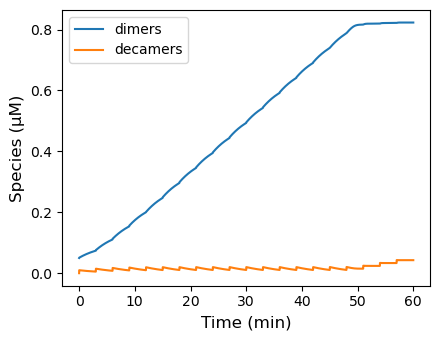

In [13]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.index/60, df_sim["dimers"], label = "dimers")
axarr.plot(df_sim.index/60,df_sim["decamers"], label = "decamers")

axarr.set_xlabel(f'Time (min)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'Species ({mu}M)',fontsize = mpl_ylabel_fontsize)
axarr.legend()

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"ITC_mod_species_vs_time.pdf"),dpi= mpl_dpi)

/tmp/ipykernel_8819/2703635833.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


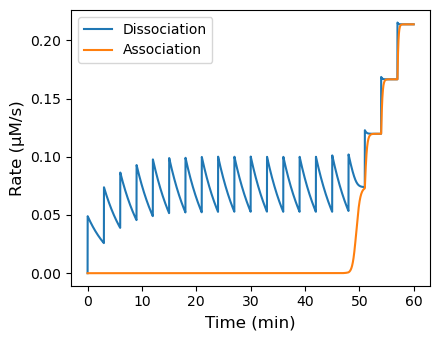

In [14]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.index/60,df_sim["decamers"]*mod_ITC_Prx_dec_onestep.koff, label = "Dissociation")
axarr.plot(df_sim.index/60,
           df_sim["dimers"]**mod_ITC_Prx_dec_onestep.exponent*mod_ITC_Prx_dec_onestep.kon, 
           label = "Association")

axarr.set_xlabel(f'Time (min)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'Rate ({mu}M/s)',fontsize = mpl_ylabel_fontsize)
axarr.legend()

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"ITC_mod_rates_vs_time.pdf"),dpi= mpl_dpi)

#### Heat generation vs time (figure 3c)

In [15]:
# Calculate enthalpy
association_enthalpy = 142 # +- 24 kcal/mol of dimer
df_sim["Rate μcal/sec"] = (-df_sim["Disassociation"])*association_enthalpy*1/5*1/1000*60


/tmp/ipykernel_8819/3316235314.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


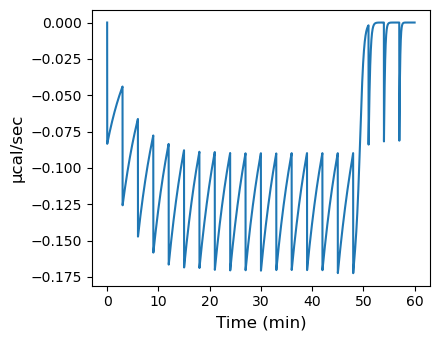

In [16]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.index/60,df_sim["Rate μcal/sec"])

axarr.set_xlabel(f'Time (min)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"ITC_mod_heat_vs_time.pdf"),dpi= mpl_dpi)

#### Heat AUC vs protein (figure 3d)

In [17]:
# Calculate AUC for each injection
points_per_inject = int(mod_ITC_Prx_dec_onestep.injection_interval)
num_injections = math.floor(df_sim.index[-1]/points_per_inject)

conversion_factor =1/(mod_ITC_Prx_dec_onestep.injection_volume*10**(-6)\
                    *(mod_ITC_Prx_dec_onestep.injection_decamer*10\
                    +mod_ITC_Prx_dec_onestep.injection_dimer*2) \
                    *1000)

heat_AUC_prot = np.zeros((num_injections,2))
start =0
for i in range(num_injections):
    x = df_sim.loc[start]["dimers"]*2 + df_sim.loc[start]["decamers"]*10
    
    x_range = data[start:start+points_per_inject,0]
    y = auc(x_range,df_sim["Rate μcal/sec"][start:start+points_per_inject])*conversion_factor
    
    heat_AUC_prot[i,0] = x
    heat_AUC_prot[i,1] = y

    start += points_per_inject

/tmp/ipykernel_8819/1591602283.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


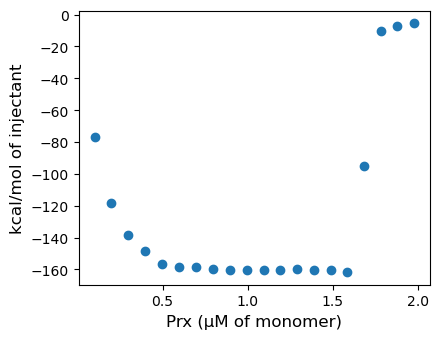

In [18]:
rows = 1
cols = 1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(heat_AUC_prot[:,0],heat_AUC_prot[:,1],"o")

axarr.set_xlabel(f'Prx ({mu}M of monomer)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'kcal/mol of injectant',fontsize = mpl_ylabel_fontsize)
# axarr.set_title("Barranco-Medina Fig 1a bottom")

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"ITC_mod_heatAUC_vs_Prx.pdf"),dpi= mpl_dpi)

### Baseline - Intrepolated 

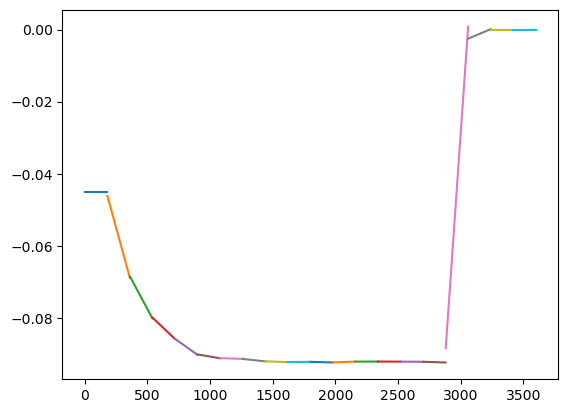

In [19]:
# Baseline correction function
num_disso_injections = math.floor(df_sim["Rate μcal/sec"].index[-1]/mod_ITC_Prx_dec_onestep.injection_interval)

start = 1
end = mod_ITC_Prx_dec_onestep.injection_interval

df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])

next_baseline = df_temp[-10:-5]

x2 = next_baseline.index.values.mean()
y2 = next_baseline["Rate μcal/sec"].mean()

x1 = 0.0
y1 = next_baseline["Rate μcal/sec"].mean()

baseline_interp = interp1d([x1,x2], [y1,y2],fill_value="extrapolate")(df_temp.index)
plt.plot(df_temp.index,baseline_interp)

current_baseline = next_baseline

df_temp["Rate μcal/sec"] = df_temp["Rate μcal/sec"] - baseline_interp

df_sim_baseline = pd.DataFrame(df_temp)

count = 1
while count < num_disso_injections:
    start = count*mod_ITC_Prx_dec_onestep.injection_interval+1
    end = count*mod_ITC_Prx_dec_onestep.injection_interval + mod_ITC_Prx_dec_onestep.injection_interval

    df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])

    next_baseline = df_temp[-10:-5]

    x2 = next_baseline.index.values.mean()
    y2 = next_baseline["Rate μcal/sec"].mean()

    x1 = current_baseline.index.values.mean()
    y1 = current_baseline["Rate μcal/sec"].mean()

    baseline_interp = interp1d([x1,x2], [y1,y2],fill_value="extrapolate")(df_temp.index)

    df_temp["Rate μcal/sec"] = df_temp["Rate μcal/sec"] - baseline_interp
    plt.plot(df_temp.index,baseline_interp)

    current_baseline = next_baseline

    df_sim_baseline = pd.concat([df_sim_baseline,df_temp])
    
    count += 1

df_sim["Rate μcal/sec baseline"] = df_sim_baseline["Rate μcal/sec"]

#### Heat generation vs time (figure 3e)

/tmp/ipykernel_8819/1589331986.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


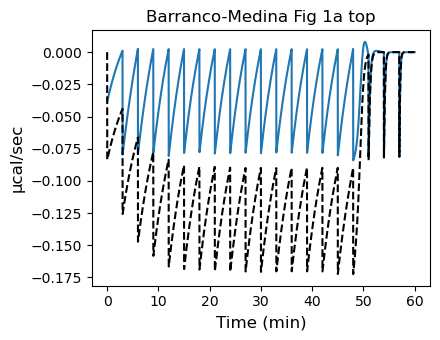

In [20]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.index/60,df_sim["Rate μcal/sec baseline"],label = "Baseline corrected data")
axarr.plot(df_sim.index/60,df_sim["Rate μcal/sec"],'k--',label = "Non-corrected data")

axarr.set_xlabel(f'Time (min)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
axarr.set_title("Barranco-Medina Fig 1a top")

f.tight_layout()
f.show()

/tmp/ipykernel_8819/1377686248.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


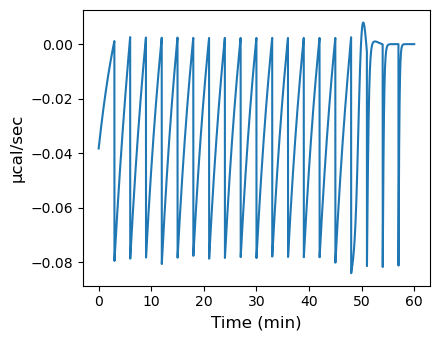

In [21]:
rows = 1
cols =1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.index/60,df_sim["Rate μcal/sec baseline"],label = "Baseline corrected data")

axarr.set_xlabel(f'Time (min)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)
# axarr.set_title("Barranco-Medina Fig 1a top")

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"ITC_mod_baseline_corr_heat_vs_time.pdf"),dpi= mpl_dpi)

#### Heat AUC vs protein (figure 3f)

In [22]:
# Calculate AUC for each injection
points_per_inject = int(mod_ITC_Prx_dec_onestep.injection_interval)
num_injections = math.floor(df_sim.index[-1]/points_per_inject)

conversion_factor =1/(mod_ITC_Prx_dec_onestep.injection_volume*10**(-6)\
                    *(mod_ITC_Prx_dec_onestep.injection_decamer*10\
                    +mod_ITC_Prx_dec_onestep.injection_dimer*2) \
                    *1000)

heat_AUC_prot = np.zeros((num_injections,2))
start =0
for i in range(num_injections):
    x = df_sim.loc[start]["dimers"]*2 + df_sim.loc[start]["decamers"]*10
    
    x_range = data[start:start+points_per_inject,0]
    y = auc(x_range,df_sim["Rate μcal/sec baseline"][start:start+points_per_inject])*conversion_factor
    
    heat_AUC_prot[i,0] = x
    heat_AUC_prot[i,1] = y

    start += points_per_inject

/tmp/ipykernel_8819/2145227336.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


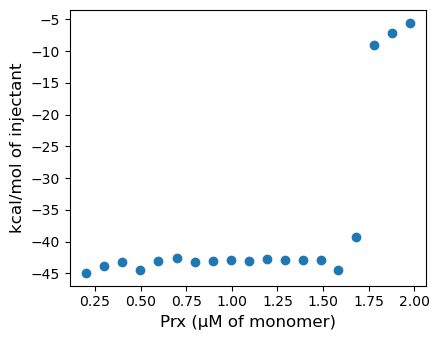

In [23]:
rows = 1
cols = 1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(heat_AUC_prot[:,0],heat_AUC_prot[:,1],"o")

axarr.set_xlabel(f'Prx ({mu}M of monomer)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'kcal/mol of injectant',fontsize = mpl_ylabel_fontsize)
# axarr.set_title("Barranco-Medina Fig 1a bottom")

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"ITC_mod_baseline_corr_heatAUC_vs_Prx.pdf"),dpi= mpl_dpi)